# Random forest

In [1]:
# DB
import psycopg
import psycopg2

# Data
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

# Machine learning
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import validation_curve
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler



# Affichage cellule
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 1000)
from pprint import pprint

# Chargement du model pour déploiement
import pickle
import joblib

### Création d'une fonction pour se connecter a la DB via psycopg2

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "diet",
    "user"      : "clement",
    "password"  : "password"
}
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

### Fonction pour transformer la DB en Dataframe


In [3]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [4]:
# Connect to the database
conn = connect(param_dic)
column_names = ["user_id","gender", "age", "height", "weight", "duration", "heart_rate", "body_temp", "calorie"]
# Execute the "SELECT *" query
df_db = postgresql_to_dataframe(conn, 
"SELECT persons.user_id as id, gender, age, height, weight, duration, heart_rate, body_temp,calorie FROM calories INNER JOIN persons ON calories.user_id = persons.user_id"
                                , column_names)
df_db.head()

Connecting to the PostgreSQL database...
Connection successful


,user_id,gender,age,height,weight,duration,heart_rate,body_temp,calorie
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


## ITERATION 1 : une caractéristique - Duration 

### Entrainement du model et visualisation de la prédiction

In [5]:
# # utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = df_db[['gender','duration','heart_rate','body_temp']]
# y unidimensionnel
y = df_db['calorie']

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

ohe=OneHotEncoder(sparse=False)
scaler = MinMaxScaler()
ct=make_column_transformer((ohe,['gender']),
                      (scaler,  ['duration','heart_rate','body_temp']),remainder='passthrough')
data_ct=ct.fit_transform(df_db)
data_ct

array([[0.00000000e+00, 1.00000000e+00, 9.65517241e-01, ...,
        1.90000000e+02, 9.40000000e+01, 2.31000000e+02],
       [1.00000000e+00, 0.00000000e+00, 4.48275862e-01, ...,
        1.66000000e+02, 6.00000000e+01, 6.60000000e+01],
       [0.00000000e+00, 1.00000000e+00, 1.37931034e-01, ...,
        1.79000000e+02, 7.90000000e+01, 2.60000000e+01],
       ...,
       [1.00000000e+00, 0.00000000e+00, 5.17241379e-01, ...,
        1.59000000e+02, 5.80000000e+01, 7.50000000e+01],
       [0.00000000e+00, 1.00000000e+00, 3.44827586e-02, ...,
        1.93000000e+02, 9.70000000e+01, 1.10000000e+01],
       [0.00000000e+00, 1.00000000e+00, 5.86206897e-01, ...,
        1.73000000e+02, 7.90000000e+01, 9.80000000e+01]])

In [7]:
ohe_True=OneHotEncoder(sparse=True)
ohe_with_sparse=ohe_True.fit_transform(df_db['gender'].values.reshape(-1,1)).toarray()
ohe_with_sparse

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [8]:
dum=pd.get_dummies(df_db,columns=['gender'],prefix='',prefix_sep='')

In [9]:
X = dum[['age', 'weight', 'duration', 'heart_rate','body_temp','female', 'male']]
y = dum.calorie

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [11]:
from sklearn import linear_model
ls = linear_model.Lasso(alpha=0)

In [12]:
ls.fit(X_train,y_train)

Lasso(alpha=0)

In [13]:
ls.score(X_test,y_test)

0.9661889410992279

## Étape 3 - Courbe d'apprentissage et scores

**estimator :** Je passer les modèles sur lesquelles je veux utiliser GridSearchCV

**train_sizes :** nombres relatifs ou absolus d'exemples de formation qui seront utilisés pour générer la courbe d'apprentissage.

**Scoring :** elle est utilisée comme métrique d'évaluation des performances du modèle pour décider des meilleurs hyperparamètres, si elle n'est pas spécifiée, elle utilise le score de l'estimateur.

**cv :** Dans ce cas, nous devons transmettre une valeur entière, car elle indique le nombre de fractionnements nécessaires pour la validation croisée. Par défaut, est défini sur cinq.

**n_jobs :** Cela signifie le nombre de travaux à exécuter en parallèle, -1 signifie utiliser tout le processeur.

In [14]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(ls, X, y, cv=10, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))



In [15]:
# Nous allons maintenant calculé la moyenne et l'écart-type des scores d'entraînement et de test.
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

## Étape 4 - Tracer la courbe d'apprentissage

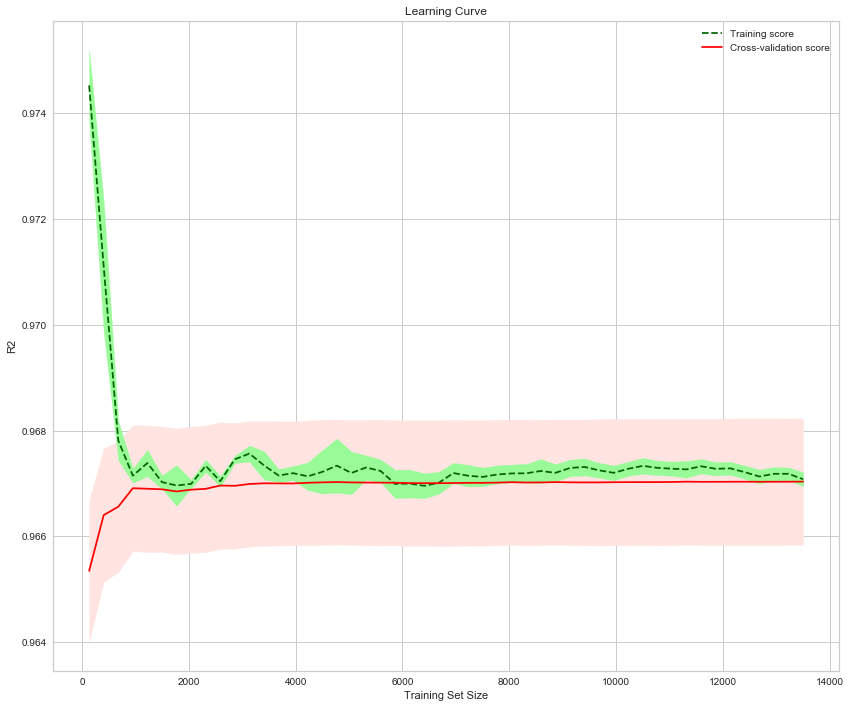

In [16]:
plt.subplots(1, figsize=(12,10))
plt.plot(train_sizes, train_mean, '--', color="darkgreen",  label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="mistyrose")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="palegreen")


plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# LASSO

In [17]:
# # utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = df_db[['duration','heart_rate','body_temp']]
# y unidimensionnel
y = df_db['calorie']

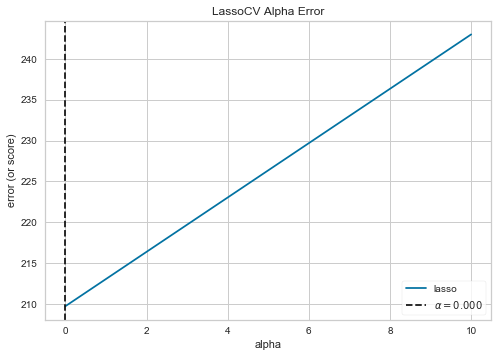

In [18]:
import numpy as np

from sklearn.linear_model import LassoCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection

# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 2)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X, y)
visualizer.show()